In [5]:

import pandas as pd
import qrcode
import os

In [2]:
# Function to generate QR code
def generate_qr_code(url, output_path):
    qr = qrcode.QRCode(version=1, error_correction=qrcode.constants.ERROR_CORRECT_L, box_size=10, border=4)
    qr.add_data(url)
    qr.make(fit=True)
    img = qr.make_image(fill_color="black", back_color="white")
    img.save(output_path)

In [3]:
# Function to create directories if they don't exist
def create_directories(good_dir, bad_dir):
    if not os.path.exists(good_dir):
        os.makedirs(good_dir)
    if not os.path.exists(bad_dir):
        os.makedirs(bad_dir)

In [13]:
# Read CSV file
csv_file = './phishing_site_urls.csv' # Change this to your CSV file name
df = pd.read_csv(csv_file)
# Output directories
good_dir = './QR_codes/good'
bad_dir = './QR_codes/bad'
create_directories(good_dir, bad_dir)

In [14]:
# Generate QR codes
for index, row in df.iterrows():
    if index == 50000: break #Only gets the first 50000 rows
    url = row['URL']
    label = row['Label'] # Assuming column name is 'Label'
    output_path = os.path.join(good_dir if label == 'good' else bad_dir, f'{index}.png')
    generate_qr_code(url, output_path)
print("QR codes generated successfully.")

QR codes generated successfully.


In [15]:
import PIL
import PIL.Image
import tensorflow as tf

In [16]:
batch_size = 32 
img_height = 180
img_width = 180
qr_path = './QR_codes'

In [21]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    qr_path,
    seed=123,
    validation_split=0.2,
    subset='both',
    image_size=(img_height, img_width),
    shuffle = True,
    batch_size=batch_size)

Found 50000 files belonging to 2 classes.
Using 40000 files for training.
Using 10000 files for validation.


2024-04-02 16:51:01.886728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


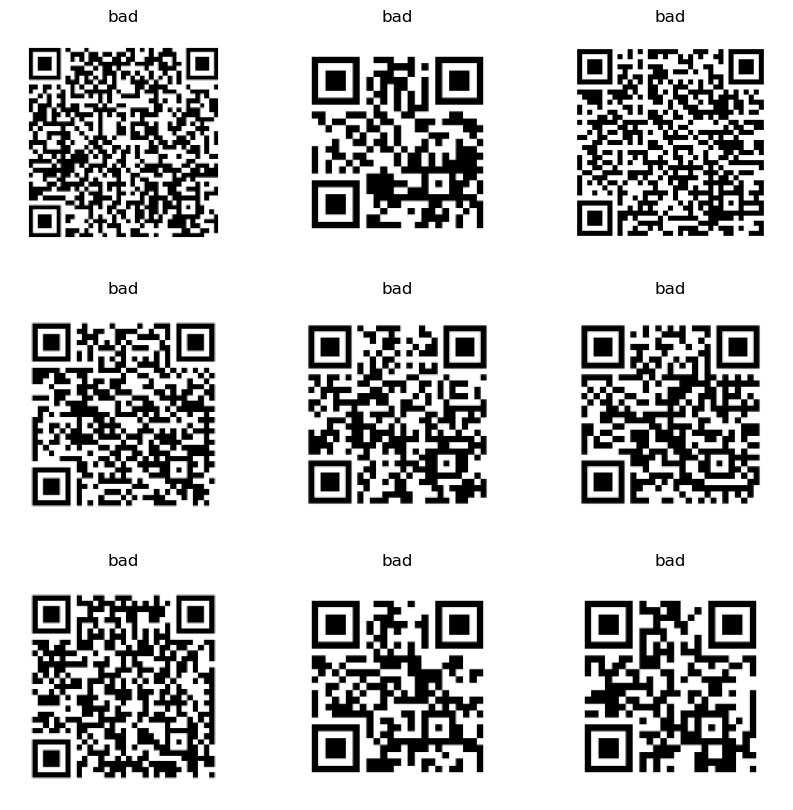

In [22]:
#Displays data 
import matplotlib.pyplot as plt
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [23]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)
